In [148]:
import numpy as np
import pandas as pd   rrregregreg
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import os
from tqdm import tqdm



#IMPORTS

In [149]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/'
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


Files already downloaded and verified


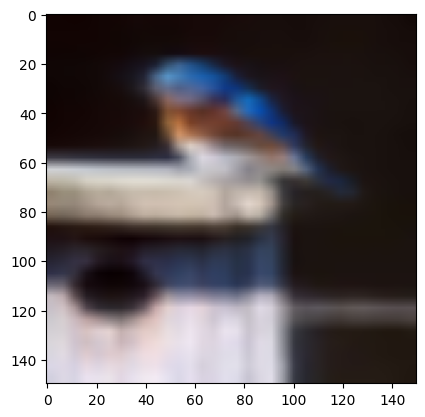

In [150]:
class dataset(Dataset):
    def __init__(self):
        self.t = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop((250,250)),transforms.Resize((150,150))])
        self.data = os.listdir(img_dir)
        self.trainp = 0.9
    def __len__(self):
        return int(len(self.data)*0.9)
    def __getitem__(self,i):
        img = self.t(mimg.imread(img_dir+self.data[i]))
        return img
d = dataset()
#t = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop((250,250)),transforms.Resize((150,150))])
t = transforms.Compose([transforms.ToTensor(),transforms.Resize((150,150))])
d = torchvision.datasets.CIFAR10(root= "/", train = True, transform= t, download= True)
loader = DataLoader(d,20)
testa = next(iter(loader))
testimg = testa[0][13]
plt.imshow(torch.permute(testimg,(1,2,0)))


In [151]:
IH = 32
IW = 32
c = 8
#^

In [152]:
"""nn.Conv2d(in_channels= 3 , out_channels= 6 , kernel_size= 5 , stride= 2 , padding= 0 )
nn.Conv2d(in_channels= 6 , out_channels= 9 , kernel_size= 3 , stride= 2 , padding= 0 )
nn.Conv2d(in_channels= 9 , out_channels= 12 , kernel_size= 3 , stride= 2 , padding= 0 )
nn.Conv2d(in_channels= 12 , out_channels= 15 , kernel_size= 3 , stride= 1 , padding= 0 )
nn.ConvTranspose2d(in_channels= 15 , out_channels= 12 , kernel_size= 3 , stride= 1 , padding= 0 )
nn.ConvTranspose2d(in_channels= 12 , out_channels= 9 , kernel_size= 3 , stride= 2 , padding= 0 )
nn.ConvTranspose2d(in_channels= 9 , out_channels= 6 , kernel_size= 3 , stride= 2 , padding= 0 )
nn.ConvTranspose2d(in_channels= 6 , out_channels= 3 , kernel_size= 5 , stride= 2 , padding= 0 )
nn.ConvTranspose2d(in_channels= 3 , out_channels= 3 , kernel_size= 3 , stride= 1 , padding= 0 )
nn.ConvTranspose2d(in_channels= 3 , out_channels= 3 , kernel_size= 4 , stride= 1 , padding= 0 )"""

'nn.Conv2d(in_channels= 3 , out_channels= 6 , kernel_size= 5 , stride= 2 , padding= 0 )\nnn.Conv2d(in_channels= 6 , out_channels= 9 , kernel_size= 3 , stride= 2 , padding= 0 )\nnn.Conv2d(in_channels= 9 , out_channels= 12 , kernel_size= 3 , stride= 2 , padding= 0 )\nnn.Conv2d(in_channels= 12 , out_channels= 15 , kernel_size= 3 , stride= 1 , padding= 0 )\nnn.ConvTranspose2d(in_channels= 15 , out_channels= 12 , kernel_size= 3 , stride= 1 , padding= 0 )\nnn.ConvTranspose2d(in_channels= 12 , out_channels= 9 , kernel_size= 3 , stride= 2 , padding= 0 )\nnn.ConvTranspose2d(in_channels= 9 , out_channels= 6 , kernel_size= 3 , stride= 2 , padding= 0 )\nnn.ConvTranspose2d(in_channels= 6 , out_channels= 3 , kernel_size= 5 , stride= 2 , padding= 0 )\nnn.ConvTranspose2d(in_channels= 3 , out_channels= 3 , kernel_size= 3 , stride= 1 , padding= 0 )\nnn.ConvTranspose2d(in_channels= 3 , out_channels= 3 , kernel_size= 4 , stride= 1 , padding= 0 )'

In [153]:
class rblock(nn.Module):
    def __init__(self,c,encoder:bool,k, s,an ):
        self.helper = [c[0]]
        super(rblock, self).__init__()
        self.enc = encoder
        self.an = an
        self.c = c
        self.k = k
        self.s = s
        self.layers = [ self.makel(i) for i in range(0,len(k))]
        
    def makel(self,i):
        if (i+1)%self.an==0:
            rv =  (nn.Sequential(nn.ConvTranspose2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]),nn.BatchNorm2d(self.c[i+1]),nn.LeakyReLU()),nn.Conv2d(self.helper[-1],self.c[i+1],1,1)) if self.enc ==False else (nn.Sequential(nn.Conv2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]),nn.BatchNorm2d(self.c[i+1]),nn.LeakyReLU()),nn.Conv2d(self.helper[-1],self.c[i+1],1,1))
            self.helper.append(self.c[i+1])
        else:
            return(nn.Sequential(nn.ConvTranspose2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]))) if self.enc == False else nn.Sequential(nn.Conv2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]))
        return rv

    def forward(self,x):
        x0=x
        y=x
        for i in range(len(self.layers)):
            y = self.layers[i][0](y)
            if((i+1))%self.an==0:
                y = torch.add(y,self.layers[i][1](transforms.Resize(y.shape[-2:])(x0)))
                x0 = y
        return y
        

In [154]:
class rblock(nn.Module):
    def __init__(self,c,encoder:bool,k, s,an ):
        self.helper = [c[0]]
        super(rblock, self).__init__()
        self.enc = encoder
        self.an = an
        self.c = c
        self.k = k
        self.s = s
        layers = []
        skips = []
        for i in range(0,len(k)):
            l4 = self.makel(i)
            layers.append(l4[0])
            if((i+1)%an==0):
                skips.append(l4[1])
        self.layers = nn.ModuleList(layers)
        self.skips = nn.ModuleList(skips)
    def makel(self,i):
        if (i+1)%self.an==0:
            rv =  (nn.Sequential(nn.ConvTranspose2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]),nn.LeakyReLU()),nn.Conv2d(self.helper[-1],self.c[i+1],1,1)) if self.enc ==False else (nn.Sequential(nn.Conv2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]),nn.LeakyReLU()),nn.Conv2d(self.helper[-1],self.c[i+1],1,1))
            self.helper.append(self.c[i+1])
        else:
            return(nn.Sequential(nn.ConvTranspose2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]))) if self.enc == False else nn.Sequential(nn.Conv2d(in_channels=self.c[i],out_channels= self.c[i+1] ,kernel_size= self.k[i],stride= self.s[i]))
        return rv

    def forward(self,x):
        x0=[x.clone()]
        y=x
#        for i in range(len(self.layers)):
#            y = self.layers[i][0](y)
#            if((i+1))%self.an==0:
#                y = torch.add(y,self.layers[i][1](transforms.Resize(y.shape[-2:])(x0)))
#                x0 = y
        n=0
        for i, l in enumerate(self.layers):
            y = l(y)
            if(i+1)%self.an==0:
                #y = torch.add(y,self.skips[n](transforms.Resize(y.shape[-2:])(x0[-1])))
                #x0.append(y.clone())
                n+=1
        return y
        

In [155]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.net2 = rblock((3,6,9,12,15),True,(5,3,3,3),(2,2,2,1),2)
    def forward(self, x):
        return self.net2(x)
Enc = Encoder().to(device)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = rblock((6,3,3,2,2,1),True,(3,3,3,3,3),(2,2,1,1,1),2)
        self.lin = nn.Sequential(nn.Linear(900,500),nn.Linear(500,100),nn.Linear(100,1))
        self.eproc = rblock((15,10,5,3),True,(3,3,3),(1,1,1),2)
    def forward(self, x):
        img = x[0]
        
        enc =x[1]
        enc = transforms.Resize(img.shape[-2:])(self.eproc(enc))
        imgenc = torch.cat((img,enc),1)
        return nn.Sigmoid()(self.lin(nn.Flatten()(self.net(imgenc))))

Disc = Discriminator().to(device)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.net = rblock((15,12,9,6,3,3,3),False,(3,3,3,5,3,4),(1,2,2,2,1,1),2)
    def forward(self, x):
        return self.net(x)
Gen = Decoder().to(device)


In [156]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.net2 =  self.net = rblock((3,9,12,15),True,(3,3,3),(2,2,2),2)
    def forward(self, x):
        return self.net2(x)
Enc = Encoder().to(device)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = rblock((6,3,3,2,2,1),True,(3,3,3,3,3),(2,2,1,1,1),20)
        self.lin = nn.Sequential(nn.Linear(900,500),nn.Linear(500,100),nn.Linear(100,1))
    def forward(self, x):
        return nn.Sigmoid()(self.lin(nn.Flatten()(self.net(x))))

Disc = Discriminator().to(device)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.net2 =  self.net = rblock((3,9,12,15),True,(3,3,3),(2,2,2),2)
        self.net = rblock((15,12,9,3,3),False,(3,3,3,8),(2,2,2,1),2)
    def forward(self, x):
        return self.net(self.net2(x))
Gen = Decoder().to(device)


In [157]:
"""print(Enc)
#netE.apply(weights_init)
inp = torch.randn(150*150*3 * 100)
inp = inp.view((-1,3,150,150)).to(device)
#e = Enc(inp)
g = Gen(e)
d = Disc((inp,e))
print(inp.shape,e.shape,g.shape,d.shape)"""

'print(Enc)\n#netE.apply(weights_init)\ninp = torch.randn(150*150*3 * 100)\ninp = inp.view((-1,3,150,150)).to(device)\n#e = Enc(inp)\ng = Gen(e)\nd = Disc((inp,e))\nprint(inp.shape,e.shape,g.shape,d.shape)'

In [158]:
Enc.train()
Gen.train()
Disc.train()

lr = 0.001
print(Enc.parameters())
#eOpt = torch.optim.Adam(Enc.parameters(),lr = lr)
gOpt = torch.optim.Adam(Gen.parameters(), lr = lr)
dOpt = torch.optim.Adam(Disc.parameters(), lr = 0.0012)
mae = nn.L1Loss()
bce = nn.BCELoss()

<generator object Module.parameters at 0x797a65541460>


In [159]:
torch.autograd.set_detect_anomaly(True)

  0%|          | 0/2500 [00:00<?, ?it/s]

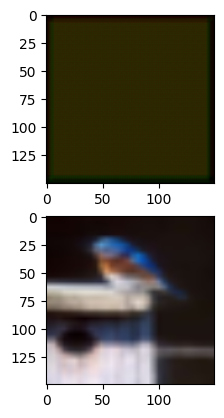

  0%|          | 3/2500 [00:00<07:07,  5.84it/s]

tensor(0.6868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(2.0091, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 449/2500 [00:32<02:25, 14.07it/s]

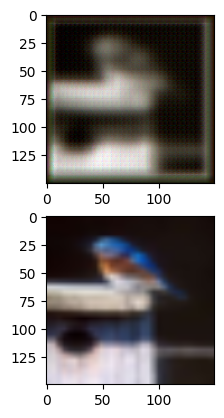

 18%|█▊        | 453/2500 [00:33<03:38,  9.35it/s]

tensor(0.6905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(1.0954, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 899/2500 [01:05<01:54, 14.04it/s]

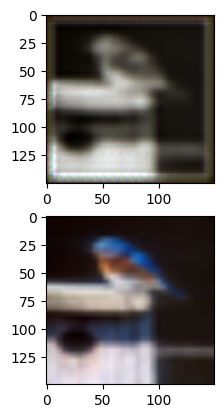

 36%|███▌      | 903/2500 [01:06<02:51,  9.29it/s]

tensor(0.6951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9779, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 1349/2500 [01:38<01:20, 14.24it/s]

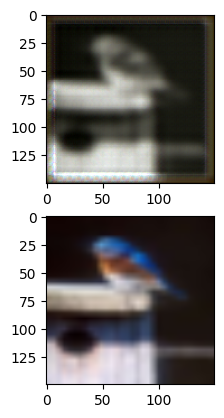

 54%|█████▍    | 1353/2500 [01:38<02:03,  9.29it/s]

tensor(0.6995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(1.0049, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 1799/2500 [02:10<00:50, 13.75it/s]

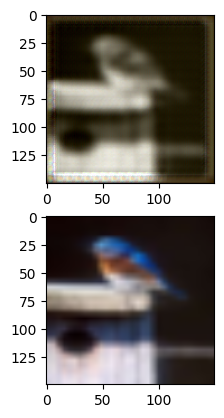

 72%|███████▏  | 1803/2500 [02:11<01:16,  9.09it/s]

tensor(0.7190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9927, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 2249/2500 [02:43<00:19, 12.75it/s]

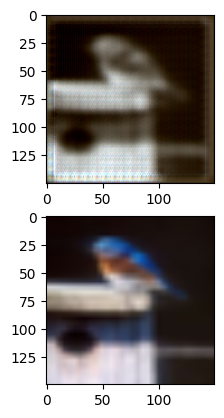

 90%|█████████ | 2253/2500 [02:44<00:27,  8.90it/s]

tensor(0.6623, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9803, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/2500 [00:00<?, ?it/s]

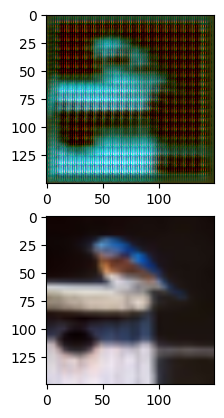

  0%|          | 3/2500 [00:00<07:08,  5.82it/s]

tensor(0.6577, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(1.3841, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 449/2500 [00:33<02:27, 13.87it/s]

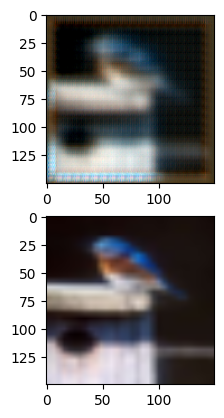

 18%|█▊        | 453/2500 [00:33<03:41,  9.24it/s]

tensor(0.6908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9383, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 899/2500 [01:06<01:55, 13.91it/s]

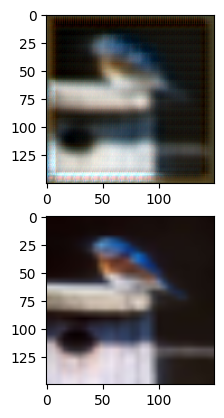

 36%|███▌      | 903/2500 [01:07<02:54,  9.13it/s]

tensor(0.6946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8782, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 1349/2500 [01:40<01:23, 13.72it/s]

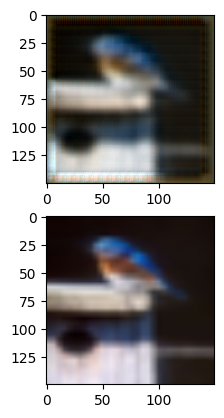

 54%|█████▍    | 1353/2500 [01:40<02:06,  9.06it/s]

tensor(0.6898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8716, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 1799/2500 [02:13<00:50, 13.93it/s]

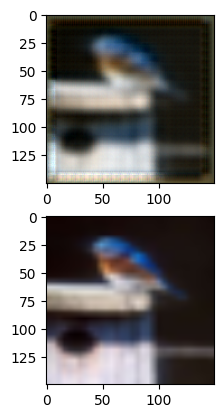

 72%|███████▏  | 1803/2500 [02:14<01:16,  9.15it/s]

tensor(0.6925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8784, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 2249/2500 [02:46<00:18, 13.85it/s]

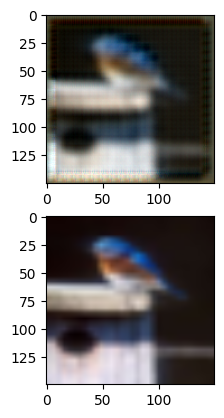

 90%|█████████ | 2253/2500 [02:47<00:27,  9.00it/s]

tensor(0.6972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8678, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/2500 [00:00<?, ?it/s]

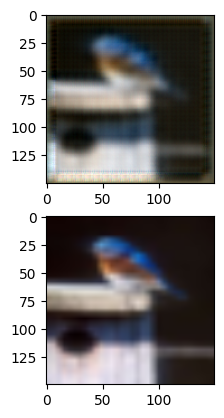

  0%|          | 3/2500 [00:00<06:59,  5.95it/s]

tensor(0.6939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8638, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 449/2500 [00:33<02:31, 13.58it/s]

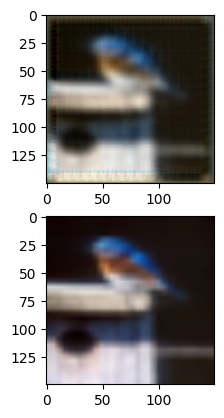

 18%|█▊        | 453/2500 [00:34<03:50,  8.90it/s]

tensor(0.6945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 899/2500 [01:07<01:55, 13.82it/s]

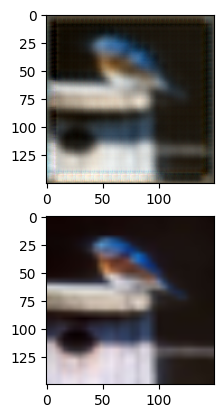

 36%|███▌      | 903/2500 [01:08<03:58,  6.69it/s]

tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8128, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 1349/2500 [01:41<01:24, 13.67it/s]

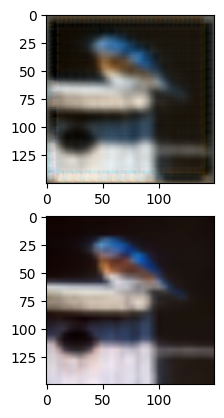

 54%|█████▍    | 1353/2500 [01:42<02:07,  9.01it/s]

tensor(0.6822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8202, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 1799/2500 [02:15<00:51, 13.55it/s]

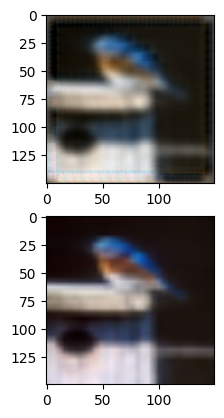

 72%|███████▏  | 1803/2500 [02:16<01:18,  8.92it/s]

tensor(0.6926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8220, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 2249/2500 [02:49<00:18, 13.66it/s]

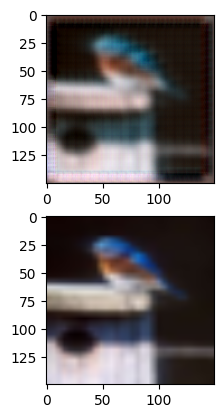

 90%|█████████ | 2253/2500 [02:50<00:27,  9.04it/s]

tensor(0.7031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8599, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/2500 [00:00<?, ?it/s]

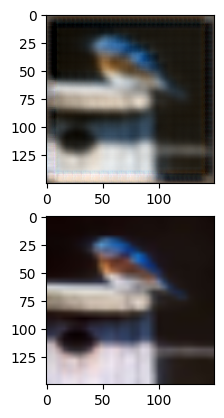

  0%|          | 3/2500 [00:00<06:55,  6.01it/s]

tensor(0.6928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8302, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 299/2500 [00:22<02:47, 13.15it/s]


KeyboardInterrupt: 

In [160]:
for epoch in range(0,10):
    for l in enumerate(tqdm(loader)):
        #print(l[1][0])
        Disc.zero_grad()
        im = l[1][0].to(device)
        lspace = Enc(im)
        recon = Gen(im)
        doutr = Disc(torch.cat((im,im),1))
        dlossr = bce(doutr,torch.ones_like(doutr))
        doutf = Disc(torch.cat((recon,im),1))
        dlossf = bce(doutf,torch.zeros_like(doutf))
        dlossr.backward(retain_graph = True)
        dlossf.backward(retain_graph = True)
        dOpt.step()
        
        Gen.zero_grad()
        lspace2 = Enc(im)
        recon2= Gen(im)
        doutf2 = Disc(torch.cat((recon2,im),1))
        gloss = bce(doutf2,torch.ones_like(doutf2))+(4*mae(recon,im))
        gloss.backward(retain_graph = True)
        gOpt.step()

        if(l[0]%450==0):
            f, axarr = plt.subplots(2,1) 
            axarr[0].imshow(torch.permute(Gen(testa[0].to(device)).to("cpu").detach()[13],(1,2,0)))
            axarr[1].imshow(torch.permute(testa[0][13],(1,2,0)).detach().to("cpu"))
            plt.show()
            print(dlossr,gloss)
        torch.cuda.empty_cache()
        del im
        del lspace
        del recon
        del doutf
        del doutr

        
"""        Enc.zero_grad()
        lspace3 = Enc(im)
        recon3 = Gen(lspace3)
        doutf3 = Disc((recon3,lspace3))
        eloss = bce(doutf3,torch.zeros_like(doutf3)) +(4*mae(im,recon3))
        eOpt.step()

        eloss.backward()"""

In [ ]:
##MORE TRAINING NEEDED. LIMITED BY KAGGLE GPU QUOTA 😭😭😭😭